In [1]:
__author__ = 'Yumi Choi <yumi.choi@noirlab.edu>'
__version__ = '20231127' 
__datasets__ = ['phat_v2']  
__keywords__ = ['M31', 'stars', 'interactive plot', 'plot:cmd', 'plot:sed']

# Exploring Resolved Stellar Populations in M31 with PHAT

*Yumi Choi & the Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
* Learn how to use an SQL query to make Healpix maps of PHAT brick number as well as young and old stellar populations 
* Learn how to retrieve data for each brick and plot color-magnitude diagrams and broad-band spectral energy distribution for individual stars
* Explore how stellar populations and photometry quality vary across the M31 disk

# Summary
Our own galaxy, the Milky Way (MW), provides detailed views of astrophysical processes, anchoring much of our understanding about galaxy formation and evolution. However, because we are observing the MW while residing in it, our observations suffer from complications arising from line-of-sight reddening, uncertain distances, and background/ foreground confusion. Studying external galaxies, which are free of these projection effects, instead offers a much cleaner view of an entire galaxy. The closest massive galaxy to MW, the Andromeda galaxy (also known as M31) provides a superb laboratory, as its proximity still allows us to resolve its individual stars but is far enough away to observe the entire galaxy.

and it contains a wide range of local enviornments consisting of young and old stellar populations. It also has various structures including spiral arms, star-forming rings, bar, and bulge. 

The Panchromatic Hubble Andromeda Treasury (PHAT; PI Dalcanton) was a Hubble Space Telescope Multi-cycle program to map roughly a third of M31's star forming disk, using 6 filters covering from the ultraviolet through the near infrared. 


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

* PHAT Reduction paper: Williams et al., "Reducing and Analyzing the PHAT Survey with the Cloud", ApJS, 2018, 236, 4: https://ui.adsabs.harvard.edu/abs/2018ApJS..236....4W

<a class="anchor" id="import"></a>
# Imports and setup

In [1]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import random

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# Explore the main PHAT object table
The notebook `M31withPhat` listed available tables in the PHAT databse. This notebook will use the main PHAT object table, phat_v2.phot_mod, which contains combined average photometry.

### Examine the columns of the phat_v2.phot_mod table

First, query 10 rows from phat_v2.phot_mod just to get all columns.

In [2]:
query = """SELECT *
           FROM phat_v2.phot_mod
           LIMIT 10
        """

In [3]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

### Convert the output to a Pandas Dataframe
Convert the result, which is by default a CSV formatted string, to a Pandas dataframe.

In [4]:
df = convert(result,'pandas')
print("Number of columns:",len(df.columns))
print(df.columns)

Number of columns: 88
Index(['ra', 'dec', 'htm9', 'pix256', 'pix4096', 'random_id', 'x', 'y', 'ir_x',
       'ir_y', 'f110w_rate', 'f110w_raterr', 'f110w_vega', 'f110w_err',
       'f110w_chi', 'f110w_snr', 'f110w_sharp', 'f110w_round', 'f110w_crowd',
       'f160w_rate', 'f160w_raterr', 'f160w_vega', 'f160w_err', 'f160w_chi',
       'f160w_snr', 'f160w_sharp', 'f160w_round', 'f160w_crowd', 'f275w_rate',
       'f275w_raterr', 'f275w_vega', 'f275w_err', 'f275w_chi', 'f275w_snr',
       'f275w_sharp', 'f275w_round', 'f275w_crowd', 'f336w_rate',
       'f336w_raterr', 'f336w_vega', 'f336w_err', 'f336w_chi', 'f336w_snr',
       'f336w_sharp', 'f336w_round', 'f336w_crowd', 'f475w_rate',
       'f475w_raterr', 'f475w_vega', 'f475w_err', 'f475w_chi', 'f475w_snr',
       'f475w_sharp', 'f475w_round', 'f475w_crowd', 'f814w_rate',
       'f814w_raterr', 'f814w_vega', 'f814w_err', 'f814w_chi', 'f814w_snr',
       'f814w_sharp', 'f814w_round', 'f814w_crowd', 'f814w_f475w',
       'f475w_f336w', '

<a class="anchor" id="chapter1"></a>
# Make a Healpix map of the brick number

PHAT tiled the survey area with 23 bricks. Each brick consists of a 3$\times$6 mosaic of 18 HST pointings.

One of the columns in the PHAT object table, pix4096, is the Healpix index (NSIDE=4096, nested scheme) for the objects's RA and Dec. Healpix is a handy tesselation of the sky into tiles of equal area. To make maps of aggregate quantities in PHAT, we're going to use the database to return results in a query grouped by Healpix index value.  We can then put the results into arrays, and use `healpy`'s functionality to display the maps.

In this first query, the GROUP BY clause tells the database to aggregate the results by the values in the pix4096 column, and return the average RA and Dec of objects in those groups, as well as the pix4096 value itself and the count of the number of objects in the group.

In [5]:
query = """SELECT avg(ra) as ra0, avg(dec) as dec0, pix4096, count(pix4096) as nb, 
            avg(brick) as brick
           FROM phat_v2.phot_mod
           WHERE f475w_gst=1 AND f814w_gst=1 AND 
            f475w_vega-f814w_vega>-0.5 AND f475w_vega-f814w_vega<0.25 AND f814w_vega<24
           GROUP BY pix4096
          """

In [6]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [7]:
df_MS = convert(result,'pandas')
print("Number of rows:", len(df_MS))

Number of rows: 2511


In [8]:
(rarot,decrot)=(np.median(df_MS['ra0']),np.median(df_MS['dec0']))

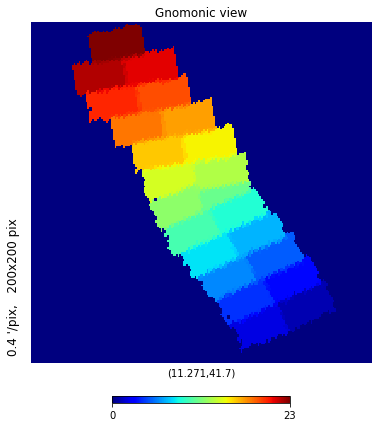

In [9]:
brickmap = np.zeros(hp.nside2npix(4096))
brickmap[df_MS['pix4096']] = df_MS['brick']
hp.gnomview(brickmap,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='jet',min=0,max=23)

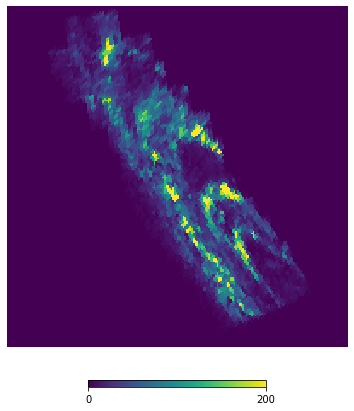

In [10]:
msmap = np.zeros(hp.nside2npix(4096))
msmap[df_MS['pix4096']] = df_MS['nb']
hp.gnomview(msmap, title='', notext=True, reso=0.4, nest=True, 
            rot=(rarot,decrot,0), norm="%LogNorm", max=200)

### RGB spatial distribution

In [11]:
query = """SELECT pix4096, count(pix4096) as nb
           FROM phat_v2.phot_mod
           WHERE f110w_gst=1 AND f160w_gst=1 AND 
            f110w_vega-f160w_vega>0.75 AND f110w_vega-f160w_vega<2.0 AND 
            f160w_vega>18.5 AND f160w_vega<22.0
           GROUP BY pix4096
          """

In [12]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [13]:
df_RGB = convert(result,'pandas')
print("Number of rows:", len(df_RGB))

Number of rows: 2571


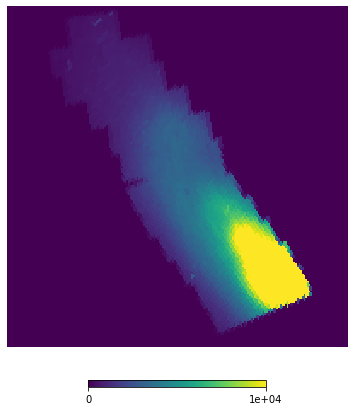

In [14]:
rgbmap = np.zeros(hp.nside2npix(4096))
rgbmap[df_RGB['pix4096']] = df_RGB['nb']
hp.gnomview(rgbmap, title='', notext=True, reso=0.4, nest=True, 
            rot=(rarot,decrot,0), norm="%LogNorm", max=1e4)

# Do query for Brick 1 (most crowded centeral region)

In [55]:
query = """SELECT f275w_vega, f336w_vega, f475w_vega, f814w_vega, f110w_vega, f160w_vega, 
            f275w_rate, f336w_rate, f475w_rate, f814w_rate, f110w_rate, f160w_rate
           FROM phat_v2.phot_mod
           WHERE ((f275w_gst=1 AND f336w_gst=1) AND 
                  (f475w_gst=1 AND f814w_gst=1) AND 
                  (f110w_gst=1 AND f160w_gst=1)) AND
                  brick=1
          """

In [56]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [57]:
df_b1 = convert(result,'pandas')
print("Number of rows:", len(df_b1))

Number of rows: 1141400


### Make UV, optical, and IR CMDs for Brick 1

Text(0.5, 1.0, 'IR CMD')

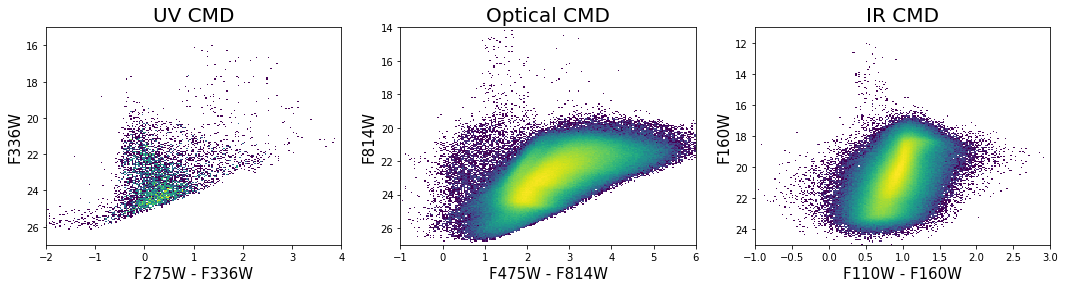

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

huv = ax1.hist2d(df_b1['f275w_vega']-df_b1['f336w_vega'],
                 df_b1['f336w_vega'], 
                 bins=200, range=((-2,4),(15,27)), 
                 norm=plt.matplotlib.colors.LogNorm())
ax1.set_xlabel('F275W - F336W',fontsize=15)
ax1.set_ylabel('F336W',fontsize=15)
ax1.set_xlim(huv[1].min(),huv[1].max())
ax1.set_ylim(huv[2].max(),huv[2].min())
ax1.set_title('UV CMD',fontsize=20)

hopt = ax2.hist2d(df_b1['f475w_vega']-df_b1['f814w_vega'], 
                  df_b1['f814w_vega'], 
                  bins=200, range=((-1,6),(14,27)), 
                  norm=plt.matplotlib.colors.LogNorm())
ax2.set_xlabel('F475W - F814W',fontsize=15)
ax2.set_ylabel('F814W',fontsize=15)
ax2.set_xlim(hopt[1].min(),hopt[1].max())
ax2.set_ylim(hopt[2].max(),hopt[2].min())
ax2.set_title('Optical CMD',fontsize=20)

hir = ax3.hist2d(df_b1['f110w_vega']-df_b1['f160w_vega'], 
                 df_b1['f160w_vega'], 
                 bins=200, range=((-1,3),(11,25)),
                 norm=plt.matplotlib.colors.LogNorm())
ax3.set_xlabel('F110W - F160W',fontsize=15)
ax3.set_ylabel('F160W',fontsize=15)
ax3.set_xlim(hir[1].min(),hir[1].max())
ax3.set_ylim(hir[2].max(),hir[2].min())
ax3.set_title('IR CMD',fontsize=20)

### Plot a broad-band spectral energy distribution of a star in Brick 1

In [59]:
stars_6b, = np.where((df_b1['f275w_vega'] < 30) & (df_b1['f336w_vega'] < 30) &
                     (df_b1['f475w_vega'] < 30) & (df_b1['f814w_vega'] < 30) & 
                     (df_b1['f110w_vega'] < 30) & (df_b1['f160w_vega'] < 30))
print('There are %d stars with detection in all 6 bands!' % (len(stars_6b))) 

There are 4909 stars with detection in all 6 bands!


In [60]:
# Pivot wavelength in nm for each filter
plambda = [270.97, 335.45, 474.44, 805.98, 1153.4, 1536.9]

Text(0, 0.5, 'F160W')

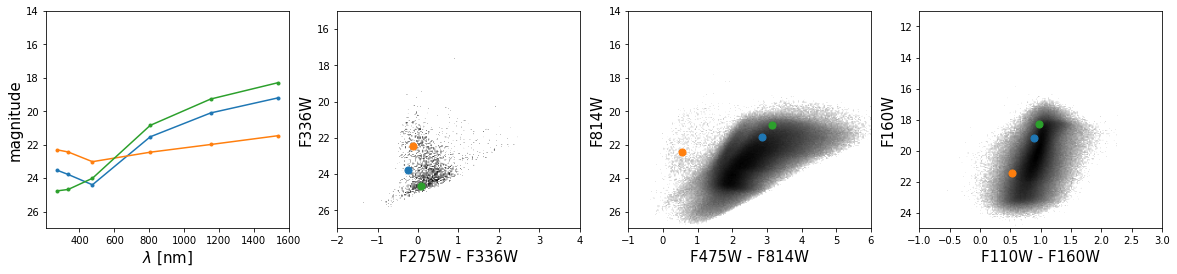

In [61]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))

sIDs = random.choices(stars_6b, k=3)
for i in sIDs:
    ax1.plot(plambda, [df_b1['f275w_vega'][i], df_b1['f336w_vega'][i], 
                       df_b1['f475w_vega'][i], df_b1['f814w_vega'][i],
                       df_b1['f110w_vega'][i], df_b1['f160w_vega'][i]], '.-')
    ax2.scatter(df_b1['f275w_vega'][i]-df_b1['f336w_vega'][i], df_b1['f336w_vega'][i], s=50)
    ax3.scatter(df_b1['f475w_vega'][i]-df_b1['f814w_vega'][i], df_b1['f814w_vega'][i], s=50)
    ax4.scatter(df_b1['f110w_vega'][i]-df_b1['f160w_vega'][i], df_b1['f160w_vega'][i], s=50)
ax1.set_ylim(27,14)
ax1.set_xlabel(r'$\lambda$ [nm]',fontsize=15)
ax1.set_ylabel('magnitude',fontsize=15)

ax2.imshow(huv[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(),
           extent=[-2,4,15,27], aspect='auto')
ax2.set_ylim(huv[2].max(),huv[2].min())
ax2.set_xlabel('F275W - F336W',fontsize=15)
ax2.set_ylabel('F336W',fontsize=15)

ax3.imshow(hopt[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(),
           extent=[-1,6,14,27], aspect='auto')
ax3.set_ylim(hopt[2].max(),hopt[2].min())
ax3.set_xlabel('F475W - F814W',fontsize=15)
ax3.set_ylabel('F814W',fontsize=15)

ax4.imshow(hir[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(),
           extent=[-1,3,11,25], aspect='auto')
ax4.set_ylim(hir[2].max(),hir[2].min())
ax4.set_xlabel('F110W - F160W',fontsize=15)
ax4.set_ylabel('F160W',fontsize=15)

# Do query for Brick 15 (10 kpc star-forming ring region)

In [62]:
query = """SELECT f275w_vega, f336w_vega, f475w_vega, f814w_vega, f110w_vega, f160w_vega, 
            f275w_rate, f336w_rate, f475w_rate, f814w_rate, f110w_rate, f160w_rate
           FROM phat_v2.phot_mod
           WHERE ((f275w_gst=1 AND f336w_gst=1) AND 
                  (f475w_gst=1 AND f814w_gst=1) AND 
                  (f110w_gst=1 AND f160w_gst=1)) AND
                  brick=15
          """

In [63]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [64]:
df_b15 = convert(result,'pandas')
print("Number of rows:", len(df_b15))

Number of rows: 658617


### Make UV, optical, and IR CMDs for Brick 15

Text(0.5, 1.0, 'IR CMD')

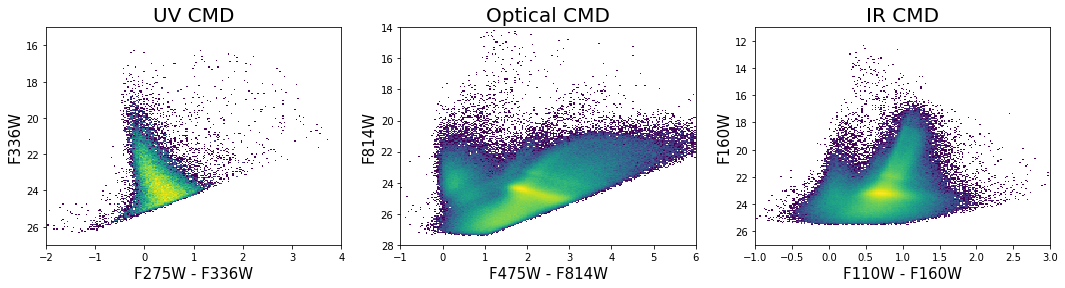

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

huv = ax1.hist2d(df_b15['f275w_vega']-df_b15['f336w_vega'],
                 df_b15['f336w_vega'], 
                 bins=200, range=((-2,4),(15,27)), 
                 norm=plt.matplotlib.colors.LogNorm())
ax1.set_xlabel('F275W - F336W',fontsize=15)
ax1.set_ylabel('F336W',fontsize=15)
ax1.set_xlim(huv[1].min(),huv[1].max())
ax1.set_ylim(huv[2].max(),huv[2].min())
ax1.set_title('UV CMD',fontsize=20)

hopt = ax2.hist2d(df_b15['f475w_vega']-df_b15['f814w_vega'], 
                  df_b15['f814w_vega'], 
                  bins=200, range=((-1,6),(14,28)), 
                  norm=plt.matplotlib.colors.LogNorm())
ax2.set_xlabel('F475W - F814W',fontsize=15)
ax2.set_ylabel('F814W',fontsize=15)
ax2.set_xlim(hopt[1].min(),hopt[1].max())
ax2.set_ylim(hopt[2].max(),hopt[2].min())
ax2.set_title('Optical CMD',fontsize=20)

hir = ax3.hist2d(df_b15['f110w_vega']-df_b15['f160w_vega'], 
                 df_b15['f160w_vega'], 
                 bins=200, range=((-1,3),(11,27)),
                 norm=plt.matplotlib.colors.LogNorm())
ax3.set_xlabel('F110W - F160W',fontsize=15)
ax3.set_ylabel('F160W',fontsize=15)
ax3.set_xlim(hir[1].min(),hir[1].max())
ax3.set_ylim(hir[2].max(),hir[2].min())
ax3.set_title('IR CMD',fontsize=20)

In [66]:
stars_6b, = np.where((df_b15['f275w_vega'] < 30) & (df_b15['f336w_vega'] < 30) &
                     (df_b15['f475w_vega'] < 30) & (df_b15['f814w_vega'] < 30) & 
                     (df_b15['f110w_vega'] < 30) & (df_b15['f160w_vega'] < 30))
print('There are %d stars with detection in all 6 bands!' % (len(stars_6b))) 

There are 31723 stars with detection in all 6 bands!


Text(0, 0.5, 'F160W')

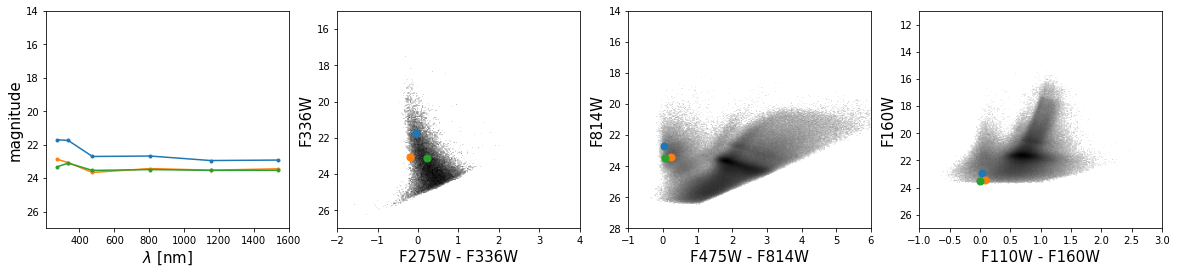

In [67]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))

sIDs = random.choices(stars_6b, k=3)
for i in sIDs:
    ax1.plot(plambda, [df_b15['f275w_vega'][i], df_b15['f336w_vega'][i], 
                       df_b15['f475w_vega'][i], df_b15['f814w_vega'][i],
                       df_b15['f110w_vega'][i], df_b15['f160w_vega'][i]], '.-')
    ax2.scatter(df_b15['f275w_vega'][i]-df_b15['f336w_vega'][i], df_b15['f336w_vega'][i], s=50)
    ax3.scatter(df_b15['f475w_vega'][i]-df_b15['f814w_vega'][i], df_b15['f814w_vega'][i], s=50)
    ax4.scatter(df_b15['f110w_vega'][i]-df_b15['f160w_vega'][i], df_b15['f160w_vega'][i], s=50)
ax1.set_ylim(27,14)
ax1.set_xlabel(r'$\lambda$ [nm]',fontsize=15)
ax1.set_ylabel('magnitude',fontsize=15)

ax2.imshow(huv[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(),
           extent=[-2,4,15,27], aspect='auto')
ax2.set_ylim(huv[2].max(),huv[2].min())
ax2.set_xlabel('F275W - F336W',fontsize=15)
ax2.set_ylabel('F336W',fontsize=15)

ax3.imshow(hopt[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(), 
           extent=[-1,6,14,27], aspect='auto')
ax3.set_ylim(hopt[2].max(),hopt[2].min())
ax3.set_xlabel('F475W - F814W',fontsize=15)
ax3.set_ylabel('F814W',fontsize=15)

ax4.imshow(hir[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(),
           extent=[-1,3,11,25], aspect='auto')
ax4.set_ylim(hir[2].max(),hir[2].min())
ax4.set_xlabel('F110W - F160W',fontsize=15)
ax4.set_ylabel('F160W',fontsize=15)

# Do query for Brick 23 (outer low-density region)

In [68]:
query = """SELECT f275w_vega, f336w_vega, f475w_vega, f814w_vega, f110w_vega, f160w_vega, 
            f275w_rate, f336w_rate, f475w_rate, f814w_rate, f110w_rate, f160w_rate
           FROM phat_v2.phot_mod
           WHERE ((f275w_gst=1 AND f336w_gst=1) AND 
                  (f475w_gst=1 AND f814w_gst=1) AND 
                  (f110w_gst=1 AND f160w_gst=1)) AND
                  brick=23
          """

In [69]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [70]:
df_b23 = convert(result,'pandas')
print("Number of rows:", len(df_b23))

Number of rows: 253181


### Make UV, optical, and IR CMDs for Brick 23

Text(0.5, 1.0, 'IR CMD')

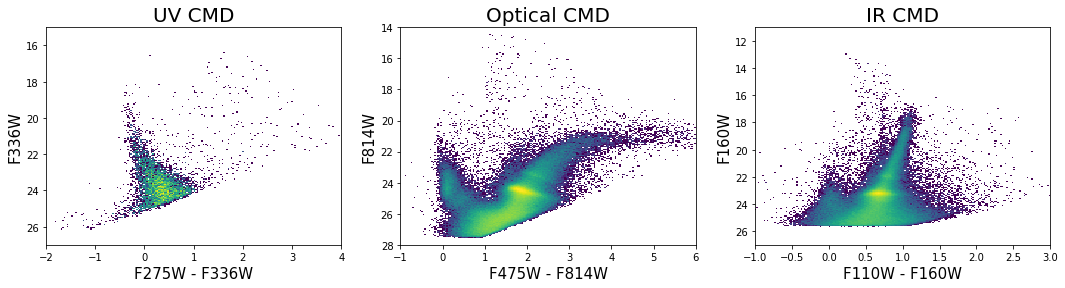

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

huv = ax1.hist2d(df_b23['f275w_vega']-df_b23['f336w_vega'],
                 df_b23['f336w_vega'], 
                 bins=200, range=((-2,4),(15,27)), 
                 norm=plt.matplotlib.colors.LogNorm())
ax1.set_xlabel('F275W - F336W',fontsize=15)
ax1.set_ylabel('F336W',fontsize=15)
ax1.set_xlim(huv[1].min(),huv[1].max())
ax1.set_ylim(huv[2].max(),huv[2].min())
ax1.set_title('UV CMD',fontsize=20)

hopt = ax2.hist2d(df_b23['f475w_vega']-df_b23['f814w_vega'], 
                  df_b23['f814w_vega'], 
                  bins=200, range=((-1,6),(14,28)), 
                  norm=plt.matplotlib.colors.LogNorm())
ax2.set_xlabel('F475W - F814W',fontsize=15)
ax2.set_ylabel('F814W',fontsize=15)
ax2.set_xlim(hopt[1].min(),hopt[1].max())
ax2.set_ylim(hopt[2].max(),hopt[2].min())
ax2.set_title('Optical CMD',fontsize=20)

hir = ax3.hist2d(df_b23['f110w_vega']-df_b23['f160w_vega'], 
                 df_b23['f160w_vega'], 
                 bins=200, range=((-1,3),(11,27)),
                 norm=plt.matplotlib.colors.LogNorm())
ax3.set_xlabel('F110W - F160W',fontsize=15)
ax3.set_ylabel('F160W',fontsize=15)
ax3.set_xlim(hir[1].min(),hir[1].max())
ax3.set_ylim(hir[2].max(),hir[2].min())
ax3.set_title('IR CMD',fontsize=20)

In [72]:
stars_6b, = np.where((df_b23['f275w_vega'] < 30) & (df_b23['f336w_vega'] < 30) &
                     (df_b23['f475w_vega'] < 30) & (df_b23['f814w_vega'] < 30) & 
                     (df_b23['f110w_vega'] < 30) & (df_b23['f160w_vega'] < 30))
print('There are %d stars with detection in all 6 bands!' % (len(stars_6b))) 

There are 6281 stars with detection in all 6 bands!


Text(0, 0.5, 'F160W')

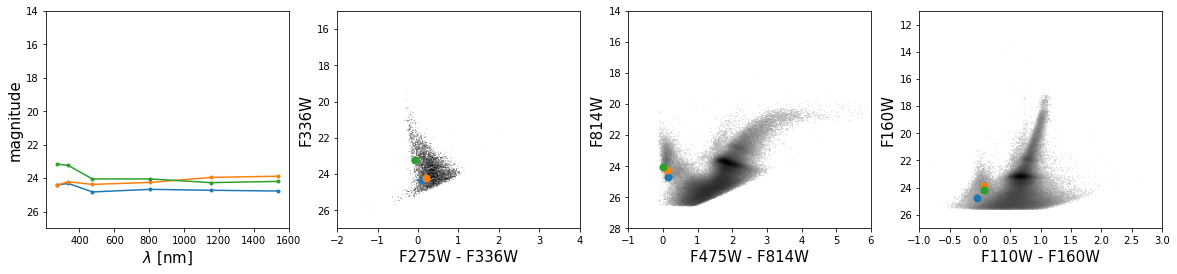

In [73]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))

sIDs = random.choices(stars_6b, k=3)
for i in sIDs:
    ax1.plot(plambda, [df_b23['f275w_vega'][i], df_b23['f336w_vega'][i], 
                       df_b23['f475w_vega'][i], df_b23['f814w_vega'][i],
                       df_b23['f110w_vega'][i], df_b23['f160w_vega'][i]], '.-')
    ax2.scatter(df_b23['f275w_vega'][i]-df_b23['f336w_vega'][i], df_b23['f336w_vega'][i], s=50)
    ax3.scatter(df_b23['f475w_vega'][i]-df_b23['f814w_vega'][i], df_b23['f814w_vega'][i], s=50)
    ax4.scatter(df_b23['f110w_vega'][i]-df_b23['f160w_vega'][i], df_b23['f160w_vega'][i], s=50)
ax1.set_ylim(27,14)
ax1.set_xlabel(r'$\lambda$ [nm]',fontsize=15)
ax1.set_ylabel('magnitude',fontsize=15)

ax2.imshow(huv[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(), 
           extent=[-2,4,15,27], aspect='auto')
ax2.set_ylim(huv[2].max(),huv[2].min())
ax2.set_xlabel('F275W - F336W',fontsize=15)
ax2.set_ylabel('F336W',fontsize=15)

ax3.imshow(hopt[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(), 
           extent=[-1,6,14,27], aspect='auto')
ax3.set_ylim(hopt[2].max(),hopt[2].min())
ax3.set_xlabel('F475W - F814W',fontsize=15)
ax3.set_ylabel('F814W',fontsize=15)

ax4.imshow(hir[0].T, origin='lower', cmap=plt.cm.gray_r, 
           norm=plt.matplotlib.colors.LogNorm(), 
           extent=[-1,3,11,27], aspect='auto')
ax4.set_ylim(hir[2].max(),hir[2].min())
ax4.set_xlabel('F110W - F160W',fontsize=15)
ax4.set_ylabel('F160W',fontsize=15)

<a class="anchor" id="resources"></a>
# Resources and references
Dalcanton, J.J. et al. (2012, ApJS, 200, 18), "The Panchromatic Hubble Andromeda Treasury"
http://adsabs.harvard.edu/abs/2012ApJS..200...18D

Williams, B.F. et al. (2023, arXiv:2307.09681), "The Panchromatic Hubble Andromeda Treasury XXI. The Legacy Resolved Stellar Photometry Catalog"
https://ui.adsabs.harvard.edu/abs/2023arXiv230709681W/abstract

In [2]:
import bokeh